## Fundos

http://dados.cvm.gov.br/dataset/fi-doc-inf_diario

http://dados.cvm.gov.br/dataset/fi-cad

http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/


## Mercado

Ações: http://www.bmfbovespa.com.br/pt_br/servicos/market-data/historico/mercado-a-vista/series-historicas/

CDI: http://estatisticas.cetip.com.br/astec/series_v05/paginas/web_v05_template_informacoes_di.asp?str_Modulo=completo&int_Idioma=1&int_Titulo=6&int_NivelBD=2

Bovespa: https://br.investing.com/indices/bovespa-historical-data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime as dt

%matplotlib inline
pd.set_option('display.max_columns', 500)

## Loading data

- Download cvm, ibov and fundos automatically

In [4]:
def load_benchmark(name, date=''):
    df = pd.read_csv(name)
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date).sort_index()
    for c in df.columns:
        df.loc[(df[c] == '0') | (df[c] == 'null') | (df[c] == ''), c] = None
        df[c] = df[c].str.replace(',', '.')
    return df.astype(float)

cdi  = load_benchmark('./data/cdi.csv',  date='data')
ibov = load_benchmark('./data/BVSP.csv', date='Date')[['Close']]
ibov.columns = [ 'ibov' ]

iix = pd.merge( cdi, ibov, right_index=True, left_index=True)
iix = iix.dropna(axis=0, how='all')

days = iix.reset_index()['index']
iix['ibov_i']  = iix['ibov'].shift(-1) / iix['ibov']
iix['cdi_i']   = ((1.0 + iix['cdi']/100.0)**(1/360.0))

existent = { i: True for i in iix.index }
for i in iix.itertuples():
    for j in range(1,10):
        _next = i.Index + dt.timedelta(days=j)
        if _next in existent: break
        iix.loc[_next, 'cdi_i'] = existent[_next] = i.cdi_i

iix = iix.sort_index()[['cdi_i', 'ibov_i']]

In [5]:
def cadastro(cnpj):
    val = fi.ix[cnpj]
    return val if type(val) == pd.core.series.Series else val.ix[0]
    
def nome(cnpj):
    return cadastro(cnpj)['DENOM_SOCIAL']
        
def search_name(name):
    return fi[fi.DENOM_SOCIAL.str.contains(name)]

fi = pd.read_csv('./data/inf_cadastral_fi.csv', sep=';', index_col=0, encoding='iso-8859-1')
fi.CLASSE = fi.apply(lambda x: 'Fundo de Credito' if 'PRIVADO' in x.DENOM_SOCIAL else x.CLASSE, axis=1)
fi = fi[~fi.index.duplicated()]

In [148]:
allFiles = glob.glob("./data/*/*.csv")

df = pd.DataFrame()
for file_ in allFiles:
    print ".",
    tmp = pd.read_csv(file_, index_col=None, header=0, sep=';')
    df  = df.append(tmp[['CNPJ_FUNDO', 'DT_COMPTC', 'VL_QUOTA', 'NR_COTST']])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


## Cleaning

In [149]:

cad = ['CLASSE', 'TRIB_LPRAZO', 'SIT', 'CONDOM', 'FUNDO_COTAS']

df  = df \
    .join(fi[cad], on='CNPJ_FUNDO', how='left') \
    .sort_values(by='DT_COMPTC') \
    .groupby(['CNPJ_FUNDO', 'DT_COMPTC']) \
    .first().reset_index()

df['DT_COMPTC']  = pd.to_datetime(df['DT_COMPTC'])
df['NR_COTST']   = df.groupby('CNPJ_FUNDO')['NR_COTST'].transform('last')

df = df[(df.SIT != 'CANCELADA') & (df.VL_QUOTA > 0.01) & (df.NR_COTST > 50)]
print df.shape, 'OUTLIERS'

(4668656, 9) OUTLIERS


In [171]:
from collections import defaultdict
import numpy as np

def comequotas(df):
    last_val   = defaultdict(int)
    last_month = defaultdict(int)
    values     = np.ones(df.shape[0])
    last_date  = df.groupby('CNPJ_FUNDO').DT_COMPTC.max()
    
    for i,row in enumerate(df.itertuples()):
        if i % 500000 == 0:
            print i

        if row.CLASSE != 'Fundo Multimercado':
            continue

        f, quota, month = row.CNPJ_FUNDO, row.VL_QUOTA, row.DT_COMPTC.month
        aliquota = (0.20 if row.TRIB_LPRAZO != 'N' else 0.15)
    
        if (last_date[f] == row.DT_COMPTC) or (last_month[f] in [5,11] and month in [6,12]):                
            diff    = quota - last_val[f]
            payload = diff * aliquota / quota

            if row.CNPJ_FUNDO == '23.979.285/0001-50':
                print row.DT_COMPTC, last_val[f], quota, diff/quota

            last_val[f] = quota
            values[i]   = 1.0 - payload
            

        last_val[f]   = last_val[f] or quota   
        last_month[f] = month
    
    return values

print df.shape

df['_i']  = (df['VL_QUOTA'] / df.groupby('CNPJ_FUNDO')['VL_QUOTA'].shift(1)).fillna(1.0)
print df.shape, '_i'

df['_ix'] = comequotas(df) * df['_i']
print df.shape, '_ix'

(4668656, 11)
(4668656, 11) _i
0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
2018-05-10 00:00:00 1.09084945 1.20181818 0.0923340417433
4500000
(4668656, 11) _ix


## Performance

In [157]:
def daily_values(df, fundos, col=None, tax=None):
    col    = col or ('_ix' if tax else '_i')
    df     = df[df.CNPJ_FUNDO.isin(fundos.keys())]
    df     = df.pivot('DT_COMPTC', 'CNPJ_FUNDO', col)
    df.columns = [ fundos[c] if c in fundos else c for c in df.columns ]
    return df

def normalize(df, since=None):
    return df / df.loc[since,:]

def accumulate(gains, begin=None):
    return begin * gains.dropna(how='all').fillna(1.0).cumprod()

def withdraw(df):
    multiplier = [ 1.0 if c not in fi.index or fi.ix[c].CLASSE == 'Fundo Multimercado' else 0.85 for c in df.columns ]
    df.iloc[-1] *= multiplier
    return df

def add_benchmarks(df):
    return df.join(iix[['cdi_i']], how='outer')

# TODO add_benchmarks, withdraw
def reconstruct(df, fundos=None, tax=True, since=None, raw=False, capital=1.0):
    quotas = daily_values(df, fundos, col='VL_QUOTA')
    since  = since or quota.dropna().index[0]
    if not raw:
        gains  = daily_values(df, fundos, tax=tax)
        quotas = accumulate(gains, begin=quotas.loc[since,:])
    return capital * normalize(quotas, since)


[26559.302968980308, 26559.302968980308]
2018-05-09 00:00:00 [25446.749693376158, 26380.901191496094]


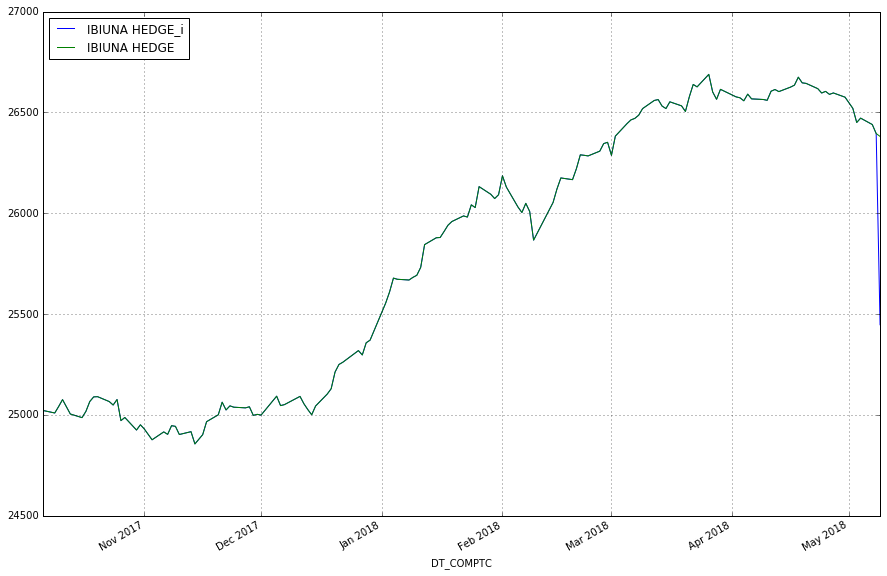

In [174]:
test = { 
    '12.154.412/0001-65': 'IBIUNA HEDGE',
#     '12.831.360/0001-14': 'NIMITZ',
#     '18.860.059/0001-15': 'ABSOLUTE HEDGE',
#     '24.029.438/0001-60': 'ADAM',
#     '23.979.285/0001-50': 'STRATEGY',
#     '14.866.273/0001-28': 'BRASIL CAPITAL',
}

SINCE = '2017-10-05'

a = reconstruct(df, fundos=test, tax=True, since=SINCE, capital=25000)
b = reconstruct(df, fundos=test, raw=True, since=SINCE, capital=25000)
# b = accumulate(iix, since='2016-05-02')

a.columns = [ i+ '_i' for i in a.columns ]

a[a.index > SINCE].plot(sharex=True, figsize=(15,10))
b[b.index > SINCE].plot(sharex=True, ax=plt.gca())

plt.grid(True)
plt.legend(loc=2)


print list(a.loc['2018-03-12'].values) + list(b.loc['2018-03-12'].values)
print a.index[-1], list(a.iloc[-1].values) + list(b.iloc[-1].values)

In [ ]:
Adam Macro Strategy Advisor...	10/05/2018	1,20181818	22921,38203428	R$ 0,00	R$ 27.037,87	R$ 27.547,33	 
Kapitalo Kappa Advisory FIC...	10/05/2018	1,17593910	13272,0694607	R$ 0,00	R$ 15.470,55	R$ 15.607,15	 
Bahia AM Maraú FIC de FIM	10/05/2018	2,28070940	9041,30520282	R$ 0,00	R$ 20.480,96	R$ 20.620,59

## Top 30 

In [450]:
from IPython.display import display, Markdown, Latex

def plot_rent(cnpj, window, **kwargs):
    hist  = search_fundo(cnpj)
    hist  = hist[~hist[window].isnull()]
    if hist.shape[0] == 0: return
    hist[window].plot(sharex=True, **kwargs)

def plot_fundo(cnpj,  **kwargs):
    hist = search_fundo(cnpj)
    base = hist['VL_QUOTA'][-1]
    quotas = hist['VL_QUOTA'] / base
    if 'label' not in kwargs:
        kwargs['label'] = ''
    kwargs['label'] += " | %.2f %.2f" % ( hist['6m_gross'][-1], hist['3y_gross'][-1] )
    quotas.plot(sharex=True, ax=plt.gca(), **kwargs)
    plt.legend(loc=0)

def plot_fundos(kwargs):
    plt.figure(figsize=(25,12))
    for k,l in kwargs.iteritems():
        plot_fundo(k, label=l)
    plt.legend(loc=2)
    plt.show()
    
def plot_topk(classe, k=30):
    fundos = fi[fi.CLASSE == classe]
    display(Markdown('### '+ classe))
    #+( str(classe) if type(classe) == float else classe ).encode('utf-8')) )
    added = 0
    for i in top.index[ top.index.isin( fundos.index ) ]:
        if added == k: break
        if cadastro(i)['CONDOM'] != 'Aberto' or cadastro(i)['FUNDO_EXCLUSIVO'] != 'N': continue
        print nome(i), i
        plot_fundo(i)
        plt.show()
        added += 1

def search_fundo(cnpj):
    return df[(df.CNPJ_FUNDO == cnpj) & (~df.VL_QUOTA.isnull())].set_index('DT_COMPTC')


In [139]:
top  = df \
    .groupby('CNPJ_FUNDO')['3y_gross'].last() \
    .sort_values(ascending=False)

### Fundo de Ações

SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES 13.199.100/0001-30


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


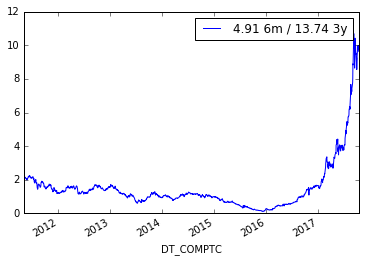

FUNDO DE INVESTIMENTO DE AÇÕES ORGANON 17.400.251/0001-66


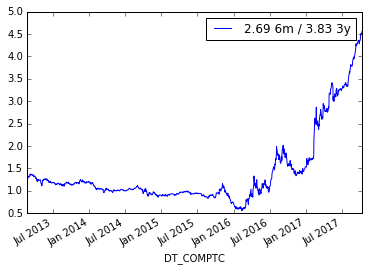

NEO FUTURE FUNDO DE INVESTIMENTO EM AÇÕES 16.816.153/0001-41


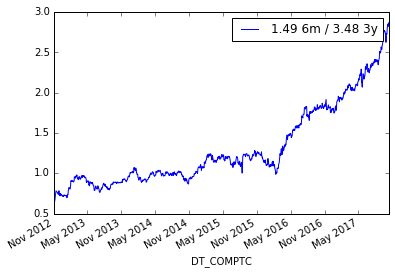

ALASKA BLACK MASTER FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL  I 12.055.107/0001-16


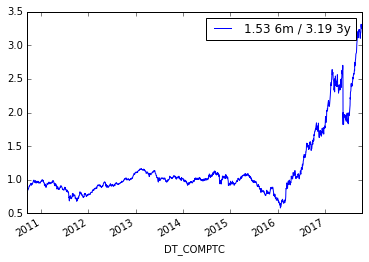

FARO CAPITAL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR 10.565.870/0001-61


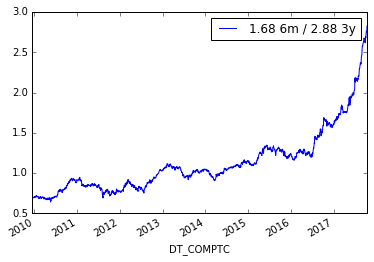

ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I 12.987.743/0001-86


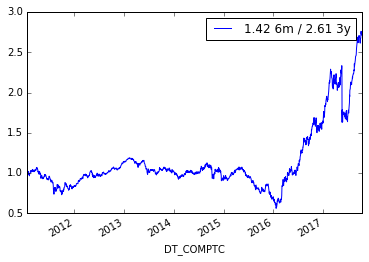

ATMOS MASTER FUNDO DE INVESTIMENTO DE AÇÕES 11.188.572/0001-62


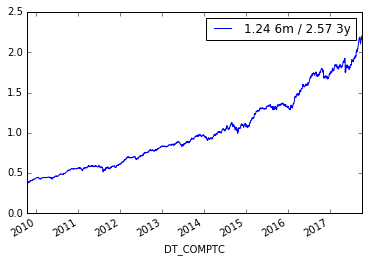

BRESSER AÇÕES MASTER FUNDO DE INVESTIMENTOS EM AÇÕES 16.993.142/0001-37


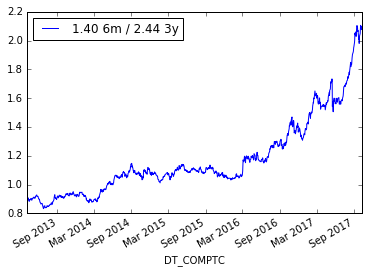

ATMOS SOL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES 11.145.366/0001-75


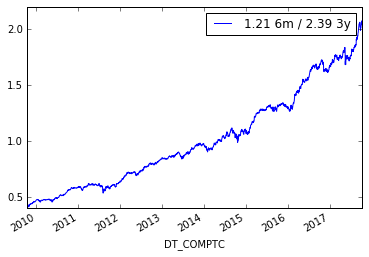

ACCESS USA COMPANIES FUNDO DE INVESTIMENTO EM AÇÕES - INVESTIMENTO NO EXTERIOR 11.147.668/0001-82


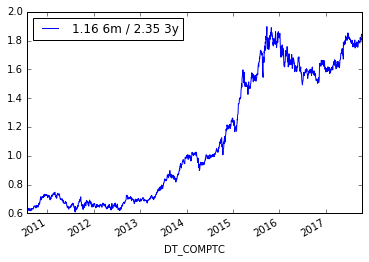

LECT FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO DE AÇÕES 97.929.197/0001-80


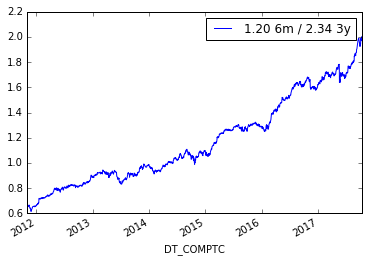

OCEANA LONG BIASED MASTER FUNDO DE INVESTIMENTO DE AÇÕES 15.174.615/0001-01


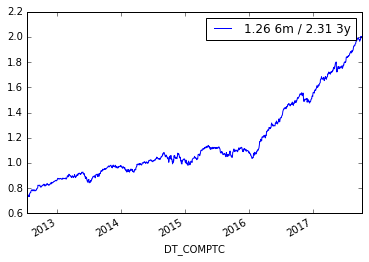

ATMOS AÇÕES FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES 11.145.320/0001-56


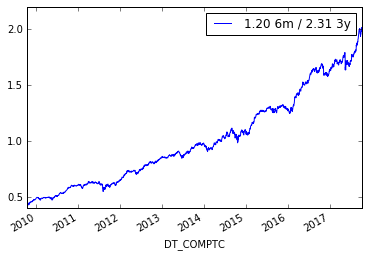

ATMOS PWM FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO AÇÕES 17.863.625/0001-80


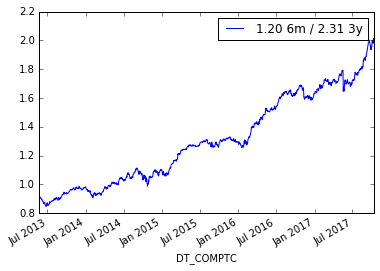

INDIE MASTER FUNDO DE INVESTIMENTO DE AÇÕES 17.335.645/0001-88


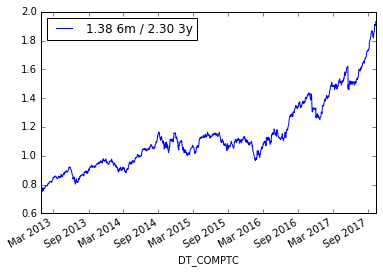

ATMOS LYRA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO AÇÕES 17.070.874/0001-18


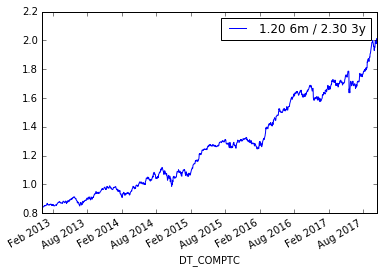

ATMOS PRIME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO AÇÕES 17.327.620/0001-32


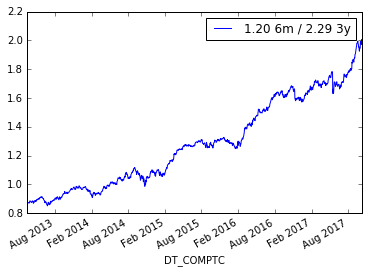

EOS HERCULES FUNDO DE INVESTIMENTO DE AÇÕES 11.490.626/0001-40


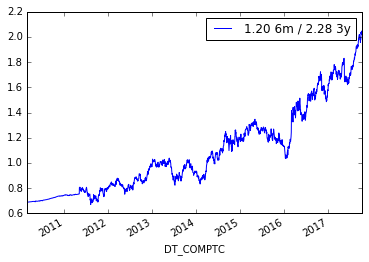

TI HOLD FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR 13.592.382/0001-31


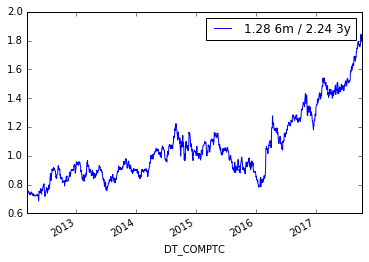

GTI DIMONA BRASIL FUNDO DE INVESTIMENTO EM AÇÕES 09.143.435/0001-60


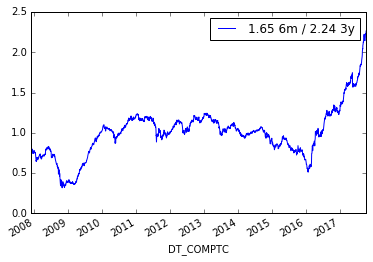

TEMPO CAPITAL PRINCIPAL FUNDO DE INVESTIMENTO DE AÇÕES 11.046.362/0001-30


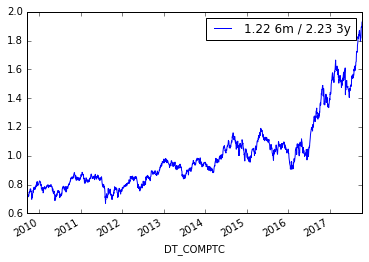

UV ARAUCÁRIA FUNDO DE INVESTIMENTO EM AÇÕES 15.715.034/0001-30


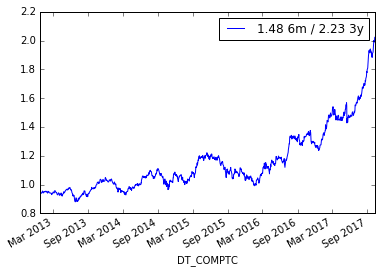

ATM FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES 15.862.847/0001-52


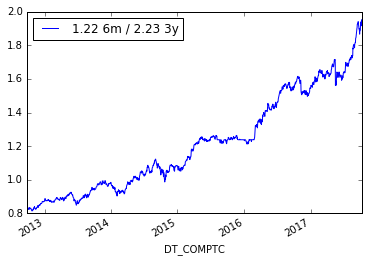

ITAÚ PHOENIX AÇÕES FUNDO DE INVESTIMENTO 09.094.073/0001-64


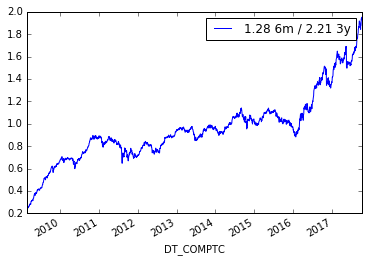

ITAÚ AÇÕES ITAÚ UNIBANCO - FUNDO DE INVESTIMENTO 08.749.127/0001-10


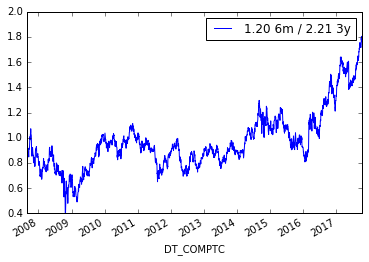

JATLAN FUNDO DE INVESTIMENTO EM AÇÕES 07.047.842/0001-48


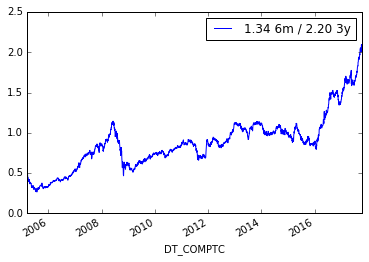

GAP EQUITY VALUE MASTER FUNDO DE INVESTIMENTO DE AÇÕES 13.549.298/0001-35


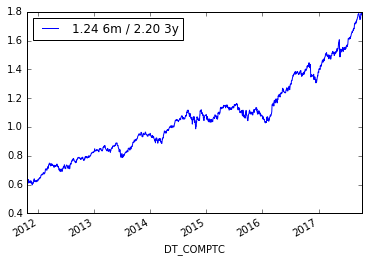

ELIZABETHA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES 11.046.271/0001-02


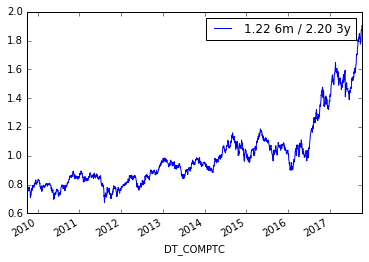

BB TOP AÇÕES SETOR FINANCEIRO FUNDO DE INVESTIMENTO 08.973.959/0001-15


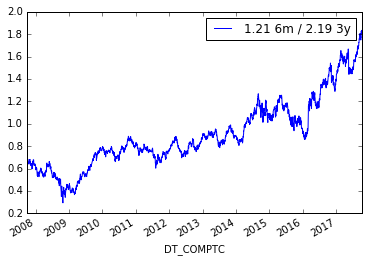

DUO GAP EQUITY VALUE FUNDO DE INVESTIMENTO DE AÇÕES 12.565.167/0001-89


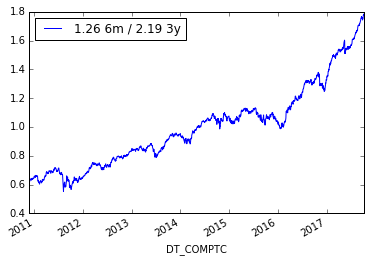

In [157]:
plot_topk(u'Fundo de Ações', k=30)

### Fundo de Credito

DUETO FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO 11.090.133/0001-12


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


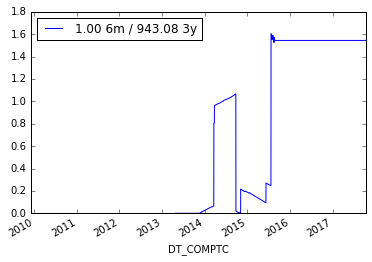

EQUIS HIGH FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO 16.984.349/0001-45


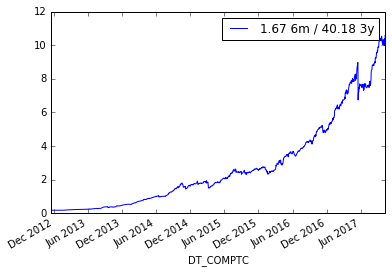

FUNDO DE INVESTIMENTO EM QUOTAS DE FI MULTIMERCADO CRÉDITO PRIVADO EQUIS - INVESTIMENTO NO EXTERIOR 14.082.760/0001-08


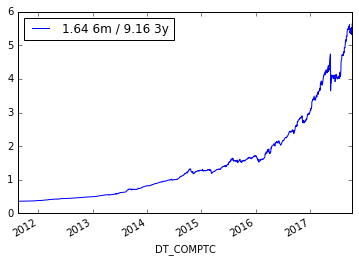

CAMBRIDGE PRIVATE FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO - INVESTIMENTO NO EXTERIOR 08.621.537/0001-80


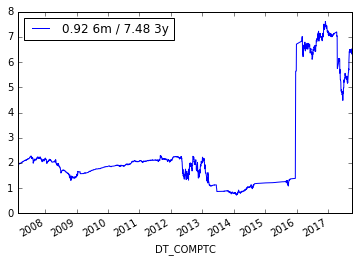

LYNX II MULTIMERCADO CRÉDITO PRIVADO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 17.072.601/0001-02


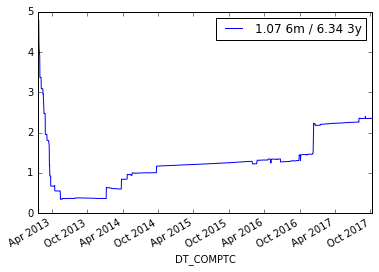

ÁRTICO FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO 07.914.836/0001-40


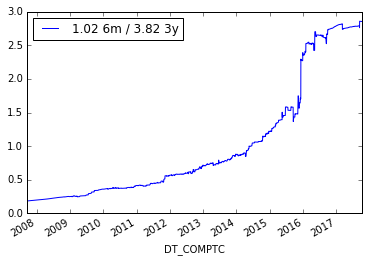

SANTOS CREDIT PLUS FUNDO DE INVESTIMENTO RENDA FIXA CRÉDITO PRIVADO 06.968.094/0001-73


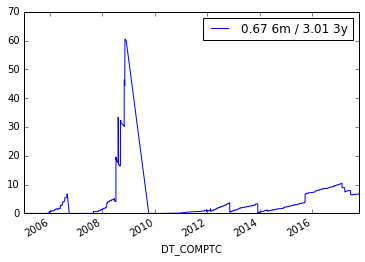

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


SPX RAPTOR MASTER FUNDO DE INVESTIMENTO NO EXTERIOR MULTIMERCADO CRÉDITO PRIVADO 12.808.980/0001-32


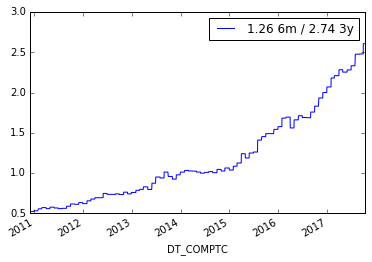

SPX RAPTOR ONE INVESTIMENTO NO EXTERIOR FIC FI MULTIMERCADO CRÉDITO PRIVADO 18.096.027/0001-95


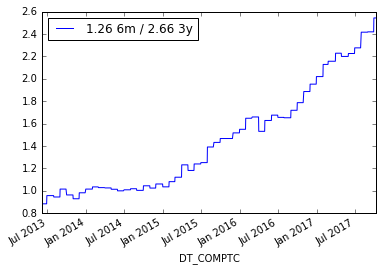

CSHG POSITANO FUNDO DE INVESTIMENTO MULTIMERCADO - CRÉDITO PRIVADO INVESTIMENTO NO EXTERIOR 97.711.812/0001-87


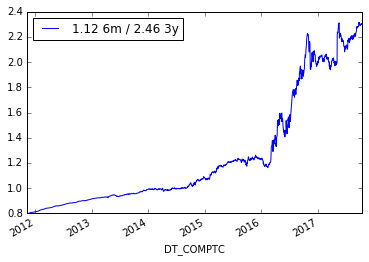

ROSTOCK FUNDO DE INVESTIMENTO MULTIMERCADO CREDITO PRIVADO INVESTIMENTO NO EXTERIOR 14.399.744/0001-35


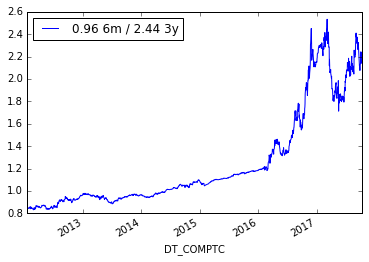

In [154]:
plot_topk('Fundo de Credito', k=40)

### Fundo Multimercado

Aberto N
CONCÓRDIA TI FUNDO DE INVESTIMENTO MULTIMERCADO LONGO PRAZO 

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


08.843.959/0001-09


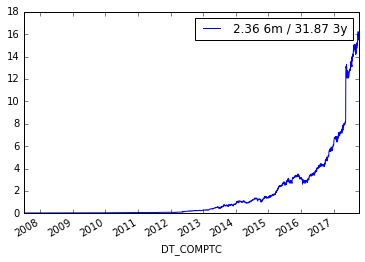

Aberto N
R&C PLUS FUNDO DE INVESTIMENTO MULTIMERCADO 12.078.239/0001-63


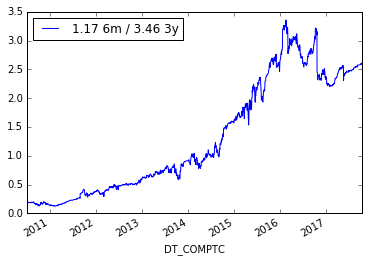

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Aberto N
KAPITALO MASTER II FUNDO DE INVESTIMENTO MULTIMERCADO 12.083.748/0001-84


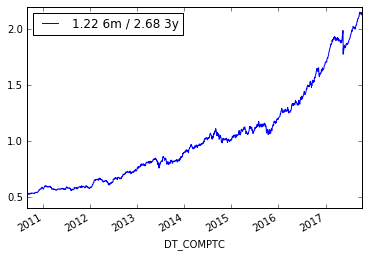

Aberto N
KAPITALO ESTRATÉGIAS MASTER FUNDO DE INVESTIMENTO MULTIMERCADO 15.831.937/0001-86


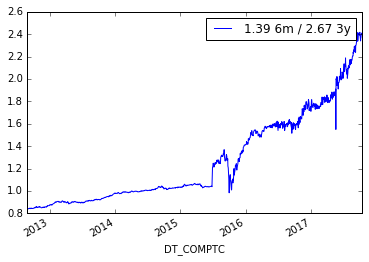

Aberto N
BRAZIL EAGLE FUNDO DE INVESTIMENTO MULTIMERCADO - INVESTIDORES NÃO RESIDENTES 14.162.755/0001-05


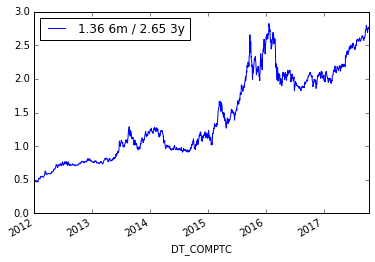

Aberto N
BAHIA AM MARAÚ MASTER RFC FUNDO DE INVESTIMENTO MULTIMERCADO 17.080.119/0001-14


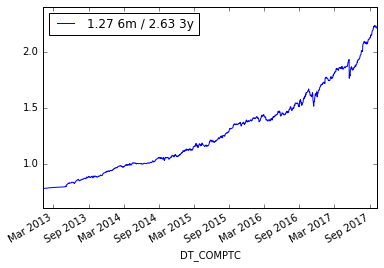

Aberto N
WESTERN ASSET US INDEX 500 FUNDO DE INVESTIMENTO MULTIMERCADO 17.453.850/0001-48


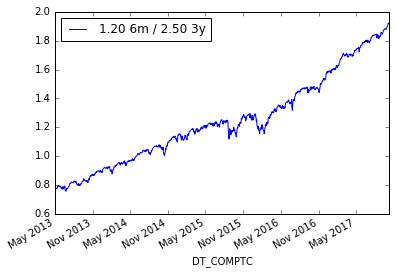

Aberto N
IBIUNA LONG BIASED MASTER FUNDO DE INVESTIMENTO MULTIMERCADO 17.554.210/0001-24


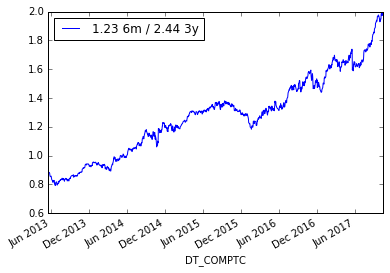

Aberto N
WM AMERICAN EQUITIES FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO 17.822.186/0001-67


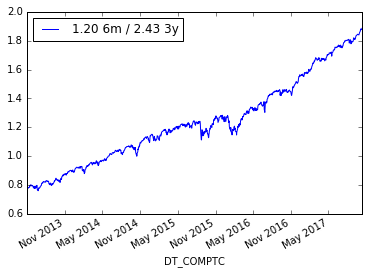

Aberto N
KADIMA HIGH VOL FUNDO DE INVESTIMENTO MULTIMERCAD 14.146.496/0001-10


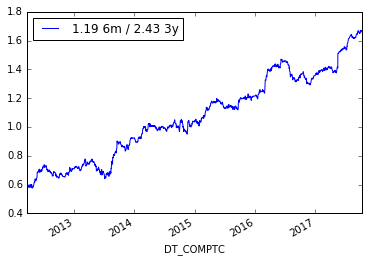

Aberto N
SAFRA S&P FUNDO DE INVESTIMENTO MULTIMERCADO 15.674.619/0001-59


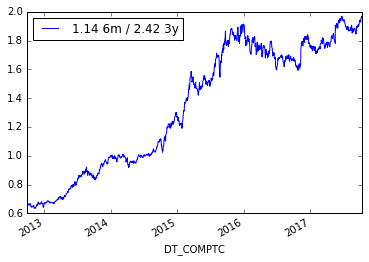

Aberto N
CSHG 931 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULT - CRED PRIV IE 13.703.693/0001-20


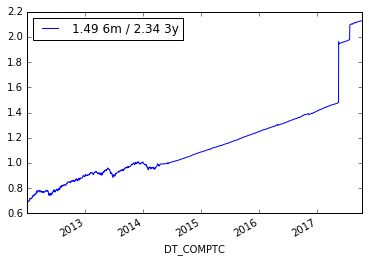

Aberto N
MURANO MASTER FUNDO DE INVESTIMENTO MULTIMERCADO 09.573.796/0001-46


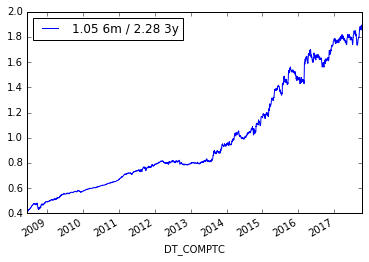

Aberto N
KAPITALO ZEVA FUNDO DE INVESTIMENTO EM QUOTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO 13.081.827/0001-19


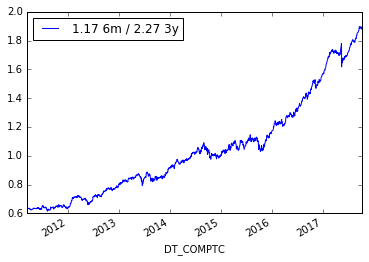

Aberto N
KAPITALO ZETA FUNDO DE INVESTIMENTO EM QUOTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO 12.105.992/0001-09


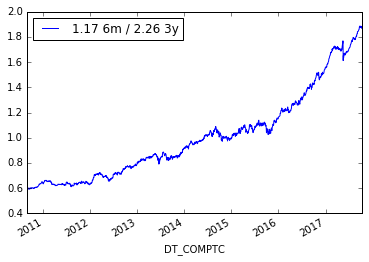

Aberto N
PACIFICO LB MASTER FUNDO DE INVESTIMENTO MULTIMERCADO 17.039.320/0001-58


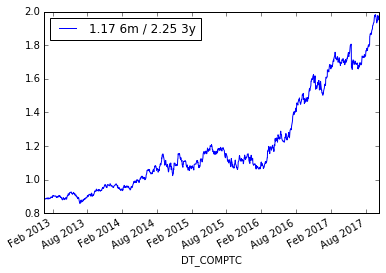

Aberto N
PLATINA TRADING FUNDO DE INVESTIMENTO MULTIMERCADO 16.566.519/0001-71


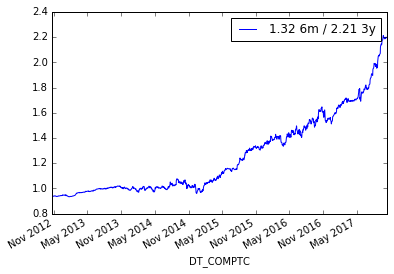

In [151]:
plot_topk('Fundo Multimercado', k=20)

### Fundo Cambial

Aberto N

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()



SUL AMÉRICA CAMBIAL FUNDO DE INVESTIMENTO 10.399.849/0001-33


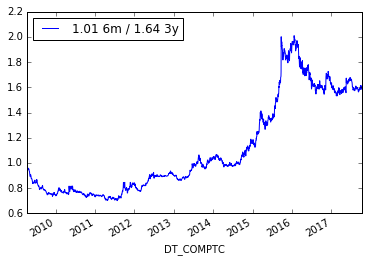

Aberto N
BB TOP DOLAR FUNDO DE INVESTIMENTO CAMBIAL LP 02.838.583/0001-50


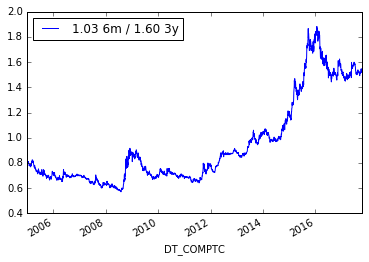

Aberto N
BB PROEX CAMBIAL LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 03.300.371/0001-87


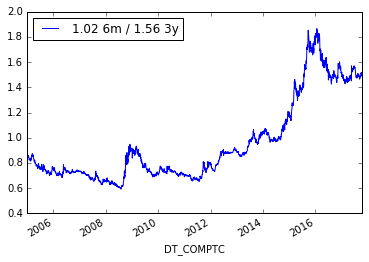

Aberto N
FUNDO DE INVESTIMENTO CAIXA MASTER CAMBIAL DÓLAR 05.164.377/0001-08


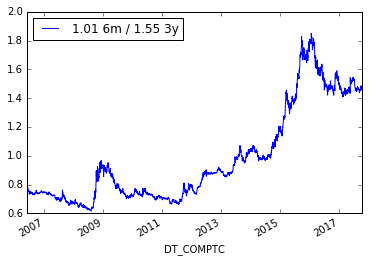

Aberto N
BB CAMBIAL DOLAR LP 100 MIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 04.061.044/0001-82


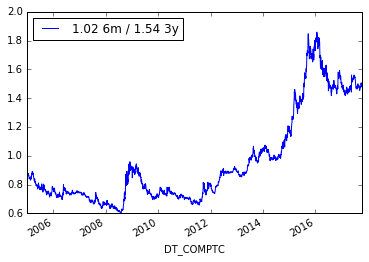

Aberto N
BB CAMBIAL DOLAR LP ESTILO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 04.128.893/0001-06


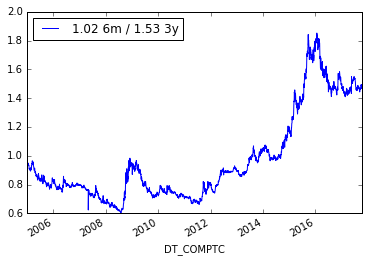

Aberto N
BB CAMBIAL DOLAR LP 20 MIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 00.822.063/0001-23


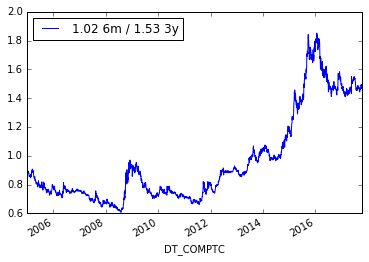

Aberto N
BB METROPOLITANO FUNDO DE INVESTIMENTO CAMBIAL LP 13.076.770/0001-60


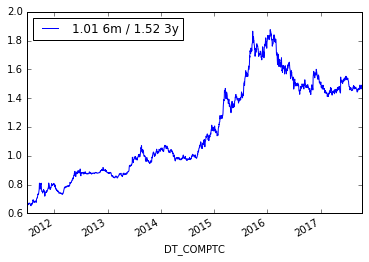

Aberto N
VOTORANTIM FUNDO DE INVESTIMENTO ALLOCATION CAMBIAL DÓLAR 09.352.825/0001-40


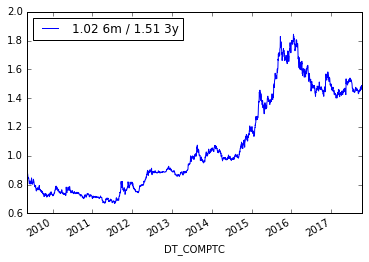

Aberto N
ITAÚ EXCHANGE CAMBIAL - FUNDO DE INVESTIMENTO 02.290.279/0001-10


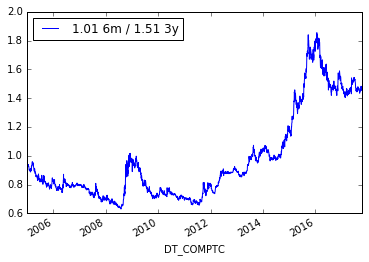

Aberto N
BRAM FUNDO DE INVESTIMENTO CAMBIAL DÓLAR 04.443.397/0001-47


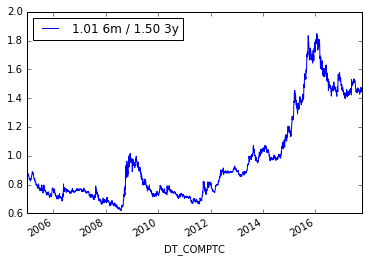

Aberto N
BRADESCO FUNDO DE INVESTIMENTO CAMBIAL DÓLAR TOP 04.875.166/0001-02


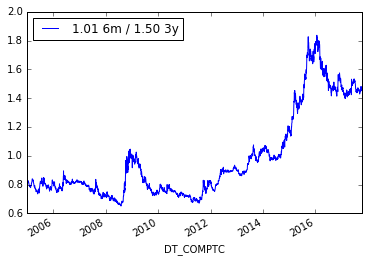

Aberto N
BB CAMBIAL DOLAR LP MIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO 03.033.971/0001-26


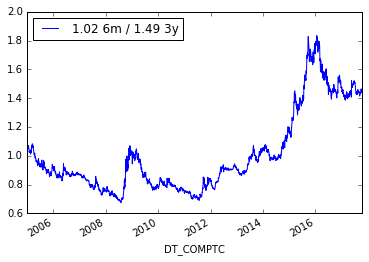

Aberto N
BRADESCO FUNDO DE INVESTIMENTO CAMBIAL DÓLAR HEDGE 03.682.381/0001-24


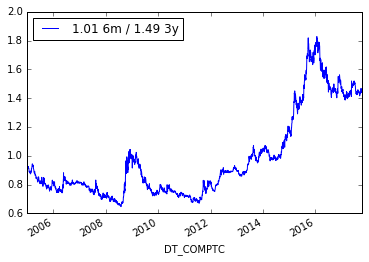

Aberto N
FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAIXA CAMBIAL DÓLAR 05.114.733/0001-70


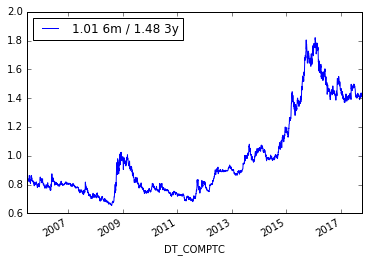

Aberto N
SANTANDER FI VIP CAMBIAL 10.362.043/0001-70


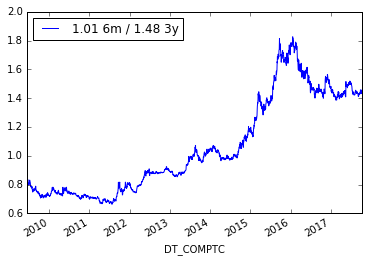

Aberto N
ITAÚ CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 01.623.535/0001-81


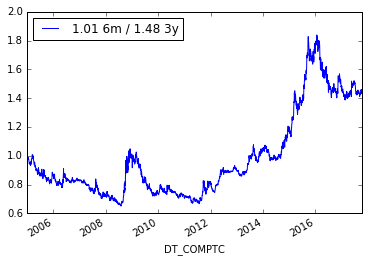

Aberto N
CSHG FUNDO DE INVESTIMENTO CAMBIAL 01.464.595/0001-07


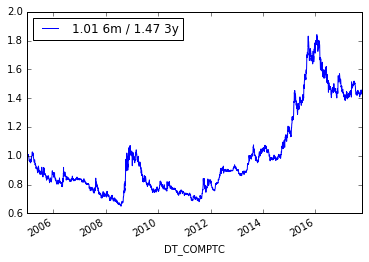

Aberto N
BRADESCO PRIVATE FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR 04.521.982/0001-18


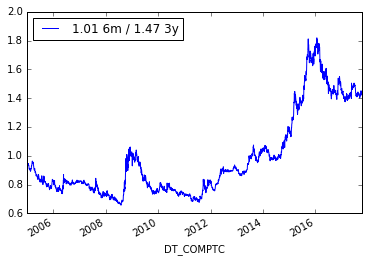

Aberto N
ITAÚ B CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO 00.822.954/0001-80


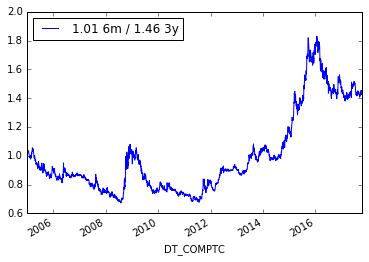

Aberto N
SAFRA CARTEIRA CAMBIAL FUNDO DE INVESTIMENTO CAMBIAL 04.103.968/0001-02


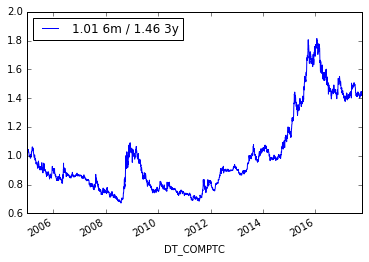

Aberto N
BRADESCO CORPORATE FUNDO DE INVESTIMENTO CAMBIAL DÓLAR HEDGE PLUS 02.225.240/0001-10


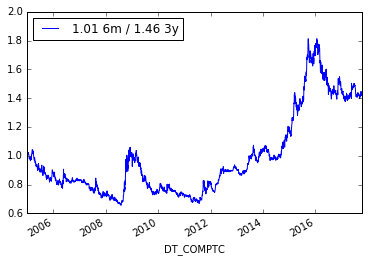

Aberto N
TOKYO-MITSUBISHI UFJ JUMP FUNDO DE INVESTIMENTO CAMBIAL DÓLAR 01.789.845/0001-70


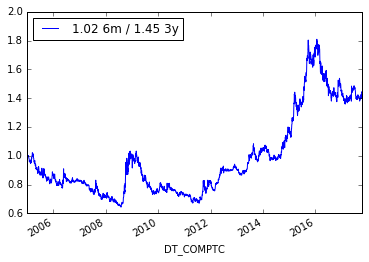

Aberto N
VOTORANTIM FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DOLAR 03.319.016/0001-50


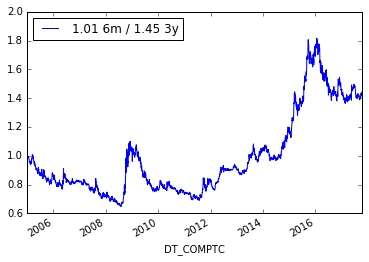

In [148]:
plot_topk('Fundo Cambial', k=15)

# Correlacao - Handpicked


In [469]:
fundos = {
    
    # first
    '12.154.412/0001-65': 'IBIUNA HEDGE',
    '18.860.059/0001-15': 'ABSOLUTE HEDGE',
    
    '08.893.082/0001-52': 'GAVEA',
    
    '09.586.692/0001-76': 'MURANO',
    
    '19.212.817/0001-51': 'GARDE',          # fechado
    '14.146.496/0001-10': 'KADIMA HIGH',
    
    # second
    
    '20.216.114/0001-80': 'CSHG GAUSS',     # 2015-01
    '12.105.940/0001-24': 'KAPITALO',       # fechado
    
    '17.453.850/0001-48': 'WESTERN ASSET',
    '15.612.413/0001-02': 'OCEANA O3',
    
    # third
    
    '23.951.048/0001-80': 'ADAM STRATEGY',  # 2017-04
    '24.029.438/0001-60': 'ADAM MACRO',
    '17.554.210/0001-24': 'IBIUNA LONG',
    
    '17.080.119/0001-14': 'BAHIA AM',
    
    
    # internacional
    
    '29.544.764/0001-20': 'IP PARTICIPACOES',
    '23.729.512/0001-99': 'PIMCO INCOME',    # 2016-02
    
    # same
    
    '14.866.273/0001-28': 'BRASIL CAPITAL',
    '10.608.762/0001-29': 'PERFIN',
    '08.323.402/0001-39': 'BOGARI VALUE',
    '07.317.588/0001-50': 'HIX CAPITAL',
    '12.823.624/0001-98': 'OCEANA LONG',

    # other - similar oceana O3
    
    '15.862.847/0001-52': 'ATM FUNDO',
    '13.106.390/0001-20': 'BTG PACTUAL',
    
    # different
    
    '18.993.924/0001-00': 'XP LONG',
    '12.055.107/0001-16': 'ALASKA BLACK',
    
    
     # cambio
    '23.711.486/0001-71': 'Brasil Plural', # 2016-01
    '03.319.016/0001-50': 'Votorantim',
    
    '22.963.439/0001-52': 'XP Gold',       # 2015-09
}

mt = df[df.CNPJ_FUNDO.isin(fundos.keys())].pivot('DT_COMPTC', 'CNPJ_FUNDO', 'VL_QUOTA')
cnpjs = mt.columns
mt.columns = [ fundos[c] for c in mt.columns ] 


In [453]:
from sklearn.cluster import *

cor = mt.corr()
cl = AffinityPropagation(affinity='precomputed')
cl.fit(cor  )

print "\n".join(map(str,sorted(zip(cl.labels_, cor.columns), key=lambda x: x[0])))

(0, 'ALASKA BLACK')
(1, 'HIX CAPITAL')
(1, 'BOGARI VALUE')
(1, 'OCEANA LONG')
(1, 'XP LONG')
(1, 'PIMCO INCOME')
(2, 'BTG PACTUAL')
(2, 'ATM FUNDO')
(2, 'IP PARTICIPACOES')
(3, 'PERFIN')
(3, 'BRASIL CAPITAL')


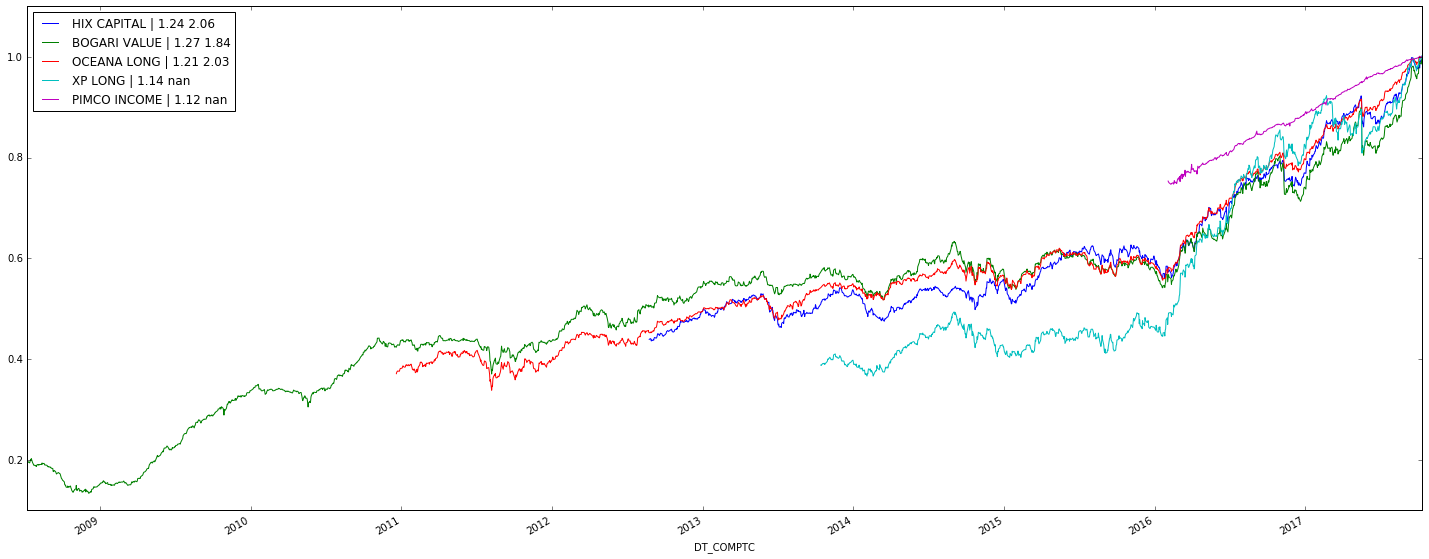

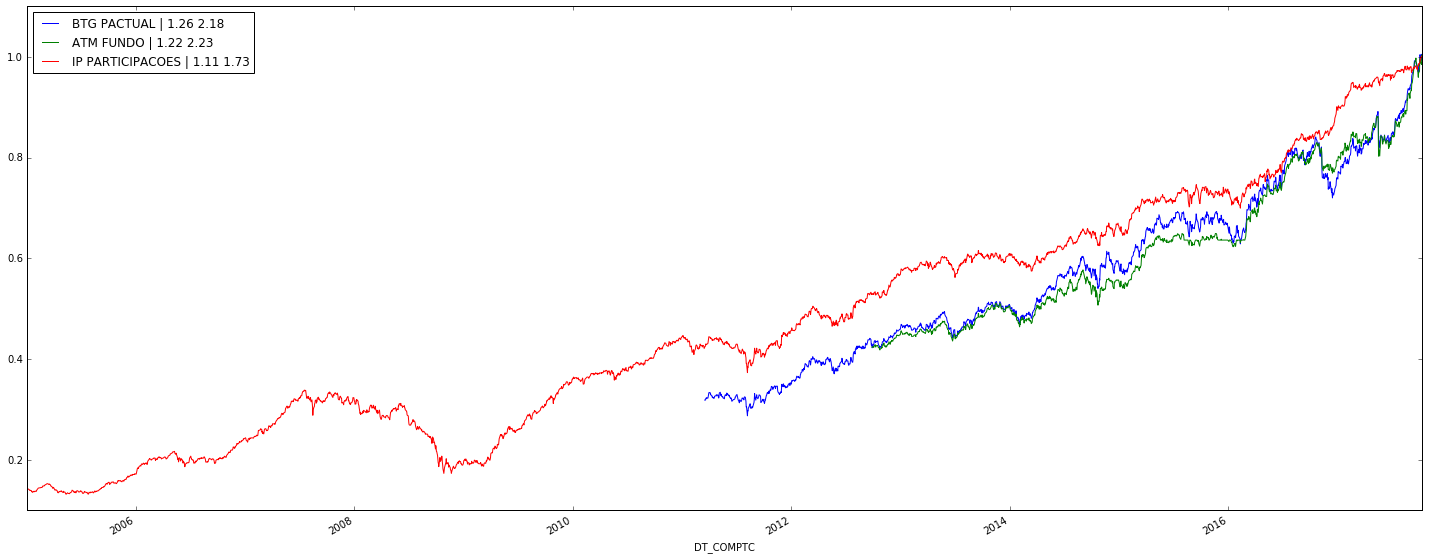

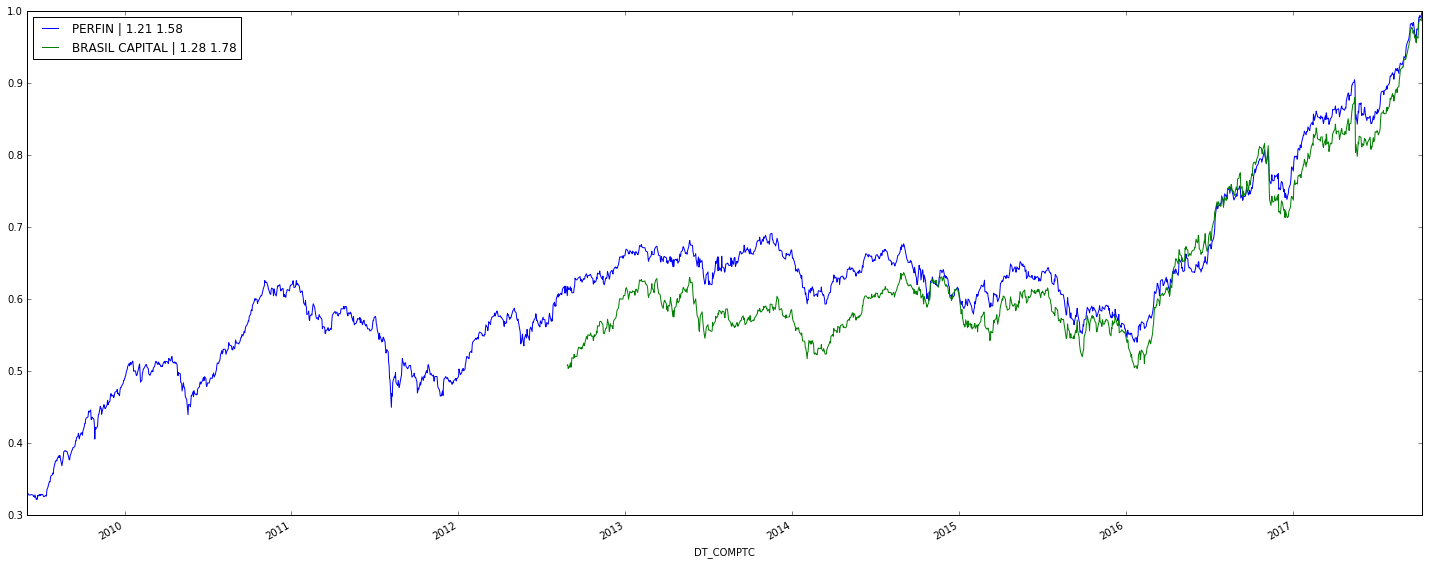

In [454]:
from collections import defaultdict

clusters = defaultdict(list)
for c,l in zip(cnpjs, cl.labels_): clusters[l].append(c) 

late = []
for c,fs in list(clusters.iteritems()) + [ ('', late) ]:
    plt.figure(figsize=(25,10))
    if len(fs) == 1:
        late.extend(fs)
        continue
    for f in fs:
        plot_fundo(f, label=fundos[f])
    plt.legend(loc=2)
    plt.show()


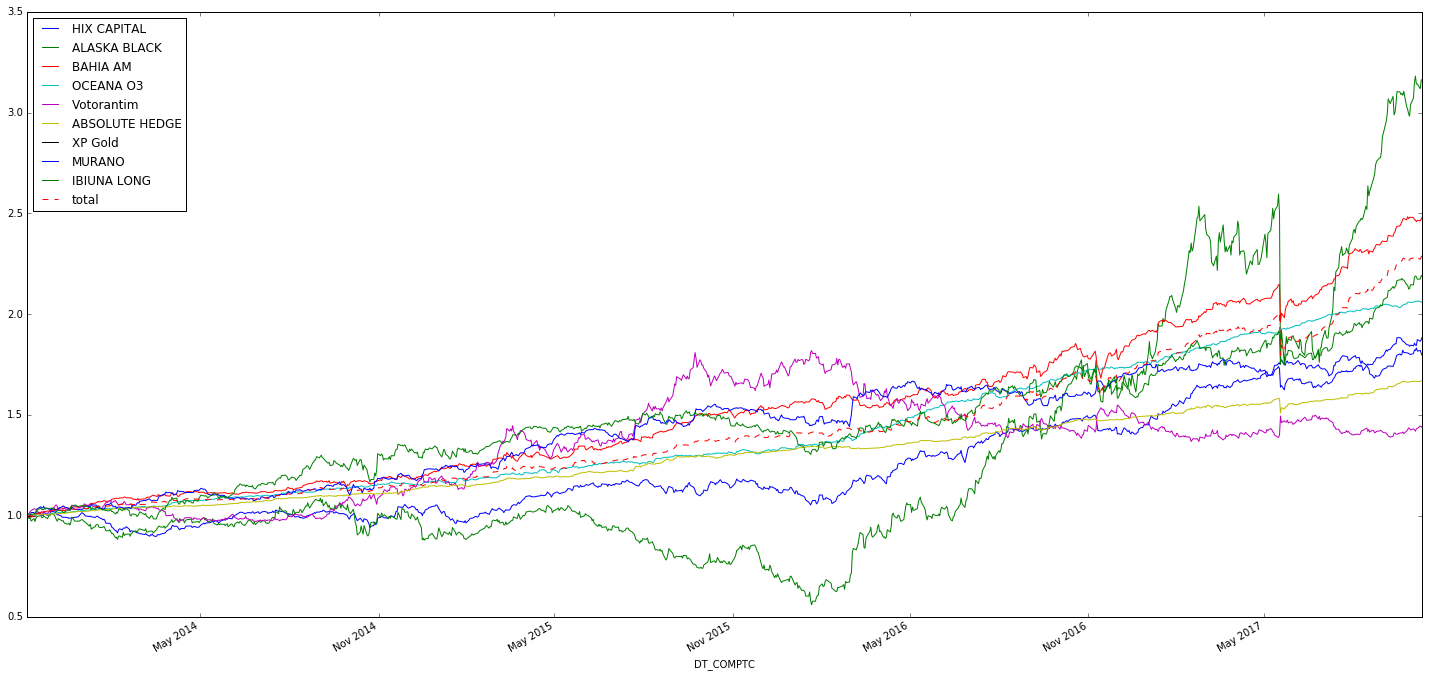

In [545]:
def simulate(kwargs):
    x = mt[ mt.index > '2013-11-01'] / mt.ix['2013-11-01']
    x['total'] = 0
    for c,w in kwargs.iteritems(): x['total'] += x[c].fillna(1)*w
    x['total'] = x['total'] / x['total'][0]
#     plt.figure(figsize=(25,12))
    x[kwargs.keys()].plot(figsize=(25,12))
    x['total'].plot(style='--')
    plt.legend(loc=2)
    
simulate({
    'ALASKA BLACK':    0.10, 
    'HIX CAPITAL':     0.00,
#     'BRASIL CAPITAL':  0.00,
#     '18.993.924/0001-00': 'XP LONG',

    'MURANO':          0.00, # quantitativo
    'IBIUNA LONG':     0.00, # similar adam - arrojado

    'ABSOLUTE HEDGE':  0.25, # conservador
    'BAHIA AM':        0.60,         
    'OCEANA O3':       0.00, # exterior - pimco?
    
    'Votorantim':      0.025,
    'XP Gold':         0.025,         # 2015-09
})

# Automatic allocation

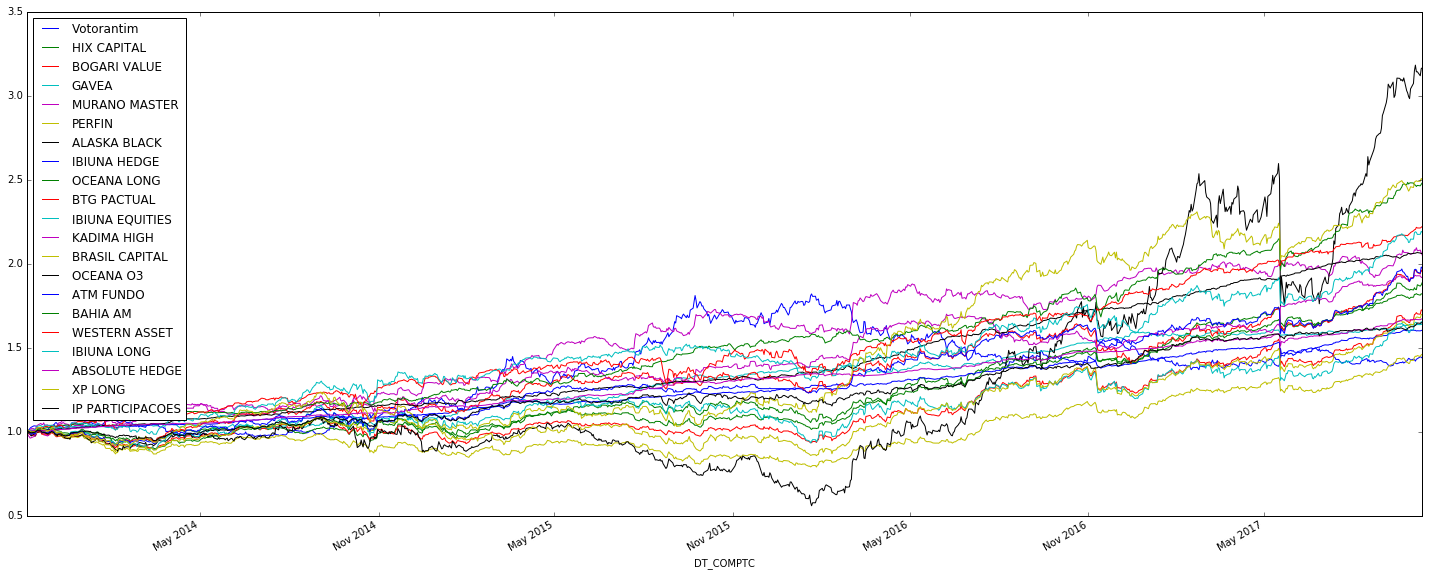

In [323]:

(mt[ mt.index > '2013-11-01'] / mt.ix['2013-11-01']).plot(figsize=(25,10))
plt.legend(loc=2)

In [504]:
prior = {
    'ALASKA BLACK':    0.07, 
    'HIX CAPITAL':     0.18, 

    'ABSOLUTE HEDGE':  0.10, # conservador
    'IBIUNA LONG':     0.20, # similar adam - arrojado
    'BAHIA AM':        0.20,         
    'MURANO':          0.10, # quantitativo
    'OCEANA O3':       0.10, # exterior - pimco?
    
    'Votorantim':      0.05,
#     'XP Gold':         0.02,         # 2015-09
}

In [505]:
(mt[ mt.index > '2013-11-01'] / mt.ix['2013-11-01'])[prior.keys()].head()

HIX CAPITAL  ALASKA BLACK  BAHIA AM  OCEANA O3  Votorantim  \
DT_COMPTC                                                                
2013-11-04     0.994203      1.006905  0.993938   0.999942    0.994311   
2013-11-05     0.993238      0.996553  0.993714   0.998187    1.011361   
2013-11-06     0.989621      0.986275  0.993423   1.001389    1.011625   
2013-11-07     0.998498      0.992702  0.996540   1.003390    1.020273   
2013-11-08     0.995954      0.973688  0.995028   1.000999    1.025519   

            ABSOLUTE HEDGE    MURANO  IBIUNA LONG  
DT_COMPTC                                          
2013-11-04        1.001470  0.991520     1.002399  
2013-11-05        1.001815  0.998806     1.009722  
2013-11-06        1.003121  0.998359     1.007109  
2013-11-07        1.003583  0.999004     1.006234  
2013-11-08        1.002875  1.016322     1.005802

In [509]:
from scipy.optimize import *

vec = (mt[ mt.index > '2013-11-01'] / mt.ix['2013-11-01'])[prior.keys()].values
x0  = [ prior[c] for c in mt.columns if c in prior.keys() ]

loss   = lambda x: -(np.dot(vec, x)).sum()
bounds = [ (0,1) for _ in x0 ]
cons   = (
    { 'type': 'eq',   'fun': lambda x:  np.sum(x) - 1 },
)

options= {
    'x0':          x0,
    'niter':       100000,
#     'accept_test': lambda f_new, x_new, f_old, x_old: bool(np.sum(x_new) == 1) and bool(np.sign(x_new).sum() == len(x_new)),
#     'disp':        True,
    'minimizer_kwargs': {
        'bounds':      bounds,
        'constraints': cons,
    }
}

a = minimize(loss, constraints=cons, bounds=bounds, x0=x0)

# a = basinhopping(loss, **options)
a # zip(mt.columns, a.x)


     fun: -1511.1142343997903
     jac: array([-1226.62084961, -1263.93463135, -1511.11424255, -1403.30653381,
       -1336.74986267, -1280.97750854, -1419.65206909, -1446.14416504,
           0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 3
    njev: 2
  status: 0
 success: True
       x: array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         3.68855643e-10,   0.00000000e+00,   0.00000000e+00,
         5.11845264e-10,   7.41066350e-10])

In [414]:
np.sum([5.71930379,   0.99202091,  -4.66480732,   1.6021769 ,
        12.33482992,  -6.17577287,   4.28662025,   3.1603043 ,
         1.53884284,   5.03637816,  -5.8953686 ,   6.33742801,
        -7.41576466,   4.09740342,   4.2694843 ,   8.89400522,
         6.21823437,   7.7127687 ,   4.88279539,   6.79268236,   2.71523483])

62.438800219999997

## Consulta

In [270]:
search_name('PIMCO INCOME')

DENOM_SOCIAL  \
CNPJ_FUNDO                                                              
27.945.462/0001-38  INVESTCENTER PIMCO INCOME FUNDO DE INVESTIMENT...   
26.470.473/0001-46  ITAÚ PERSONNALITÉ SELEÇÃO PIMCO INCOME FICFI M...   
23.729.512/0001-99  PIMCO INCOME FI EM COTAS DE FUNDOS DE INVESTIM...   
23.720.107/0001-00  PIMCO INCOME FUNDO DE INVESTIMENTO MULTIMERCAD...   

                        DT_REG    DT_CONST DT_CANCEL                      SIT  \
CNPJ_FUNDO                                                                      
27.945.462/0001-38  2017-07-07  2017-07-05       NaN     FASE PRÉ-OPERACIONAL   
26.470.473/0001-46  2017-06-12  2017-06-08       NaN  EM FUNCIONAMENTO NORMAL   
23.729.512/0001-99  2016-02-01  2016-01-29       NaN  EM FUNCIONAMENTO NORMAL   
23.720.107/0001-00  2016-02-01  2016-01-29       NaN  EM FUNCIONAMENTO NORMAL   

                    DT_INI_SIT DT_INI_ATIV              CLASSE DT_INI_CLASSE  \
CNPJ_FUNDO                                                                     
27.945.462/0001-38  2017-07-05         NaN  Fundo Multimercado    2017-07-05   
26.470.473/0001-46  2017-06-28  2017-06-28  Fundo Multimercado    2017-06-08   
23.729.512/0001-99  2016-02-03  2016-02-03  Fundo Multimercado    2016-01-29   
23.720.107/0001-00  2016-02-03  2016-02-03  Fundo Multimercado    2016-01-29   

                    RENTAB_FUNDO  \
CNPJ_FUNDO                         
27.945.462/0001-38  DI de um dia   
26.470.473/0001-46           NaN   
23.729.512/0001-99           NaN   
23.720.107/0001-00           NaN   

                                          ...                          \
CNPJ_FUNDO                                ...                           
27.945.462/0001-38                        ...                           
26.470.473/0001-46                        ...                           
23.729.512/0001-99                        ...                           
23.720.107/0001-00                        ...                           

                   INVEST_QUALIF      TAXA_PERFM VL_PATRIM_LIQ DT_PATRIM_LIQ  \
CNPJ_FUNDO                                                                     
27.945.462/0001-38             S             NaN  8.635257e+08    2017-10-10   
26.470.473/0001-46             S             NaN  7.854414e+08    2017-10-10   
23.729.512/0001-99             S  0.000000000000  1.903099e+09    2017-10-10   
23.720.107/0001-00             S  0.000000000000  5.327469e+09    2017-10-10   

                                     DIRETOR          CNPJ_ADMIN  \
CNPJ_FUNDO                                                         
27.945.462/0001-38   FERNANDO MATTAR BEYRUTI  60.701.190/0001-04   
26.470.473/0001-46   FERNANDO MATTAR BEYRUTI  60.701.190/0001-04   
23.729.512/0001-99  CARLOS AUGUSTO SALAMONDE  02.201.501/0001-61   
23.720.107/0001-00  CARLOS AUGUSTO SALAMONDE  02.201.501/0001-61   

                                                        ADMIN PF_PJ_GESTOR  \
CNPJ_FUNDO                                                                   
27.945.462/0001-38                         ITAU UNIBANCO S.A.           PJ   
26.470.473/0001-46                         ITAU UNIBANCO S.A.           PJ   
23.729.512/0001-99  BNY MELLON SERVICOS FINANCEIROS DTVM S.A.           PJ   
23.720.107/0001-00  BNY MELLON SERVICOS FINANCEIROS DTVM S.A.           PJ   

                       CPF_CNPJ_GESTOR  \
CNPJ_FUNDO                               
27.945.462/0001-38  33.311.713/0001-25   
26.470.473/0001-46  33.311.713/0001-25   
23.729.512/0001-99  14.869.060/0001-50   
23.720.107/0001-00  14.869.060/0001-50   

                                                               GESTOR  
CNPJ_FUNDO                                                             
27.945.462/0001-38                                     ITAU DTVM S.A.  
26.470.473/0001-46                                     ITAU DTVM S.A.  
23.729.512/0001-99  PIMCO LATIN AMERICA ADMINISTRADORA DE CARTEIRA...  
23.720.107/0001-00  PI